<a href="https://colab.research.google.com/github/KIHOON71/pytorch_tutorial/blob/main/pytorch_audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#audio classification


##About Audio Data

- 음향 신호는 소리가 공기를 타고 올때 생성되는 진동이다. 소리가 마이크에 포집될 때는 아날로그한 형태로 들어온다. 아날로그한 형태에서 디지털 형태로 
변환할 때는 일관된 주기로 샘플링을 해서 변환한다. 매초바다 기록된 음향 데이터의 포인트의 수를 **표본율(sample rate)라고** 한다. 
  - 표본율이 높을 수록 소리의 질도 좋아진다. 
  - 평균적으로 표본율은 48KHz 거나 초당 48000 샘플이다. 

- **Frequency**는 소리의 파장이 스스로 초당 반복하는 빈도이다.
- **Amplitude**는 소리가 얼마나 큰지의 척도이다.

- **Waweform**은 시각적으로 시간의 순서에 따라 위의 데이터를 표현한 것이다.

- 데이터를 파싱하는 경우 역시 생각해야한다.(프레임, 섹션 등)

# TorchAudio 사용하기

- I/O 함수와 유명한 데이터셋이 있다
- 활발하게 쓰이는 변환함수가 있다.

In [ ]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/audio-pytorch/install-packages.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

#데이터셋 가져오기

In [ ]:
default_dir = '/content/drive/MyDrive/Colab Notebooks/pytorch_tutorial'
folder = 'data'
print(f'Data directory will be : {default_dir}/{folder}')

if os.path.isdir( default_dir +'/' +folder):
  print('Data folder exists')
else:
  print('creating folder')
  os.mkdir(default_dir + '/'+folder)

# trainset_speechcommands = torchaudio.datasets.SPEECHCOMMANDS(f'{default_dir}/{folder}/', download=True) 

Data directory will be : /content/drive/MyDrive/Colab Notebooks/pytorch_tutorial/data
Data folder exists


#데이터셋 클래스 시각화하기

In [ ]:
os.chdir(f'{default_dir}/{folder}/SpeechCommands/speech_commands_v0.02/')
labels = [name for name in os.listdir('.') if os.path.isdir(name)]

os.chdir(default_dir)
print(f'Total Labels : {len(labels)} \n')
print(f'Label Names : {labels}')

Total Labels : 36 

Label Names : ['four', 'forward', 'off', 'five', 'on', 'yes', 'six', 'down', 'house', 'two', 'marvin', 'visual', 'up', 'seven', 'zero', 'bird', 'one', 'sheila', '_background_noise_', 'three', 'stop', 'left', 'follow', 'nine', 'wow', 'no', 'dog', 'go', 'bed', 'happy', 'learn', 'backward', 'tree', 'cat', 'eight', 'right']


## 음성을 텐서 데이터로 만들기


- torchaudio.load 함수를 통해 wav 데이터를 torch.tensor 로 바꿔준다. 
- torch.load 함수가 waveform을 텐서로 반환해준다.

In [ ]:
file_name =  default_dir + '/' + folder + '/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav'
waveform, sample_rate = torchaudio.load(filepath=file_name, num_frames=3)
print(f'waveform tensor with 3 frames : {waveform} \n')
waveform, sample_rate = torchaudio.load(filepath=file_name, num_frames=3, frame_offset=2)
print(f'waveform tensor withe 2 frame_offsets : {waveform} \n')
waveform, sample_rate = torchaudio.load(filepath=file_name)
print(f'waveform tensor : {waveform}')

waveform tensor with 3 frames : tensor([[0.0005, 0.0007, 0.0005]]) 

waveform tensor withe 2 frame_offsets : tensor([[0.0005, 0.0004, 0.0007]]) 

waveform tensor : tensor([[0.0005, 0.0007, 0.0005,  ..., 0.0008, 0.0008, 0.0007]])


## Plot the waveform


In [ ]:
def plot_audio(filename):
  waveform, sample_rate = torchaudio.load(filename)

  print(f"Shape of waveform : {waveform.size}")
  print(f'Sample rate of waveform: {sample_rate}')

  plt.figure()
  plt.plot(waveform.t().numpy())

  print('waveform : ', type(waveform))

  return waveform, sample_rate

Shape of waveform : <built-in method size of Tensor object at 0x7f380d3fae30>
Sample rate of waveform: 16000
waveform :  <class 'torch.Tensor'>


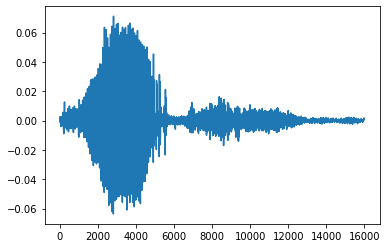

In [ ]:
data_dir = f'{default_dir}/{folder}'

file_name = data_dir + '/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav'
waveform, sample_rate = plot_audio(file_name)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Shape of waveform : <built-in method size of Tensor object at 0x7f380d0d9b30>
Sample rate of waveform: 16000
waveform :  <class 'torch.Tensor'>


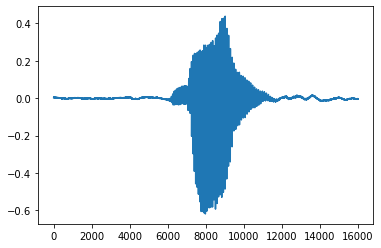

In [ ]:
file_name = data_dir + '/SpeechCommands/speech_commands_v0.02/no/0b40aa8e_nohash_0.wav'
waveform, sample_rate = plot_audio(file_name)
ipd.Audio(waveform.numpy(), rate=sample_rate)

## 음성 데이터를 시각화하는 방법

데이터를 시각화하고 변환하는 것은 모든 ai모델에 있어서 매우 중요하다. 

음성의 변환은 torch.audio를 통해서 할 것이고 다음의 3가지 형태의 변환에 대해서 알아 볼 것이다. 

- **Spectogram** : waveform으로부터 스펙토 그램을 만들어 볼 것 이다,
- **MFCC** : waveform으로부터 Mel-frequency cepstrum coefficients 을 만들어 볼 것이다.
- **MelSpectogram** : STFT 함수를 사용하여 waveform에서 Mel 스펙토그램을 만들 것이다.

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

우선 로컬에 잇는 디렉토리에서 yes와 no인 데이터를 받아 torchaudio 객체로 만들 것이다.

In [ ]:
def load_audio_files(path:str, label:str):

  dataset = []
  walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

  for i, file_path in enumerate(walker):
    path, filename = os.path.split(file_path)
    speaker, _ = os.path.splitext(filename)
    speaker_id, utterance_number =speaker.split('_nohash_')
    utterance_number = int(utterance_number)

    #Load audio
    waveform, sample_rate = torchaudio.load(file_path)
    dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])

  return dataset


In [ ]:
from torch.utils import data
trainset_speechcommands_yes = load_audio_files(data_dir+'/SpeechCommands/speech_commands_v0.02/yes', 'yes')
trainset_speechcommands_no = load_audio_files(data_dir+'/SpeechCommands/speech_commands_v0.02/no', 'no')

In [ ]:
print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')


Length of yes dataset: 4044
Length of no dataset: 3941


데이터셋을 데이터 로더에 올린다. 여기에서 batch_size를 조정하여 올릴 수 있다.

In [ ]:
trainloader_yes = DataLoader(trainset_speechcommands_yes, batch_size=1, shuffle=True, num_workers=0)
trainloader_no = DataLoader(trainset_speechcommands_no, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]} \n')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714 

No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


### Transform

#### Waveform

- wafeform은 sample_rate와 frequency에 의해 생성된다. 이는 시간에 따른 신호를 표현한 것이다. 오디오는 여러가지 채널들을 통해 녹음될 수 있다. 예를 들어, 스테레오 녹음의 경우와 좌우 채널을 통해 녹음이 된다.

- 밑의 방법은 waveform의 크기를 줄이고 다른 형태로 waveform을 변환하는 것이다.

In [ ]:
def show_waveform(waveform, sample_rate, label):
  print(f'Waveform : {waveform} \nSample rate : {sample_rate} \nLabels: {label}')
  new_sample_rate = sample_rate/10

  #Resample applies to a single channel, we resample first channel here
  channel = 0
  waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel, :].view(1,-1))

  print(f'Shape of transformed waveform : {waveform_transformed} \nSample rate : {new_sample_rate}')

  plt.figure()
  plt.plot(waveform_transformed[0,:].numpy())


Waveform : tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]]) 
Sample rate : 16000 
Labels: yes
Shape of transformed waveform : tensor([[-0.0021, -0.0043, -0.0034,  ..., -0.0006, -0.0008, -0.0011]]) 
Sample rate : 1600.0


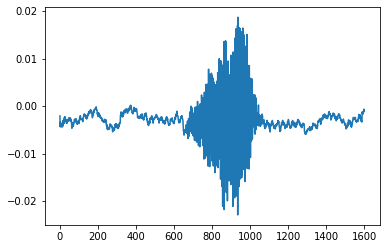

In [ ]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

Waveform : tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]]) 
Sample rate : 16000 
Labels: no
Shape of transformed waveform : tensor([[0.0035, 0.0064, 0.0051,  ..., 0.0075, 0.0082, 0.0105]]) 
Sample rate : 1600.0


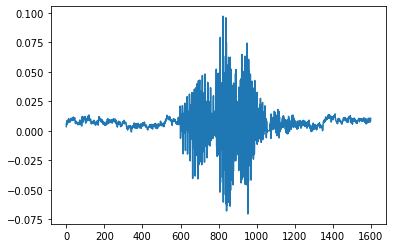

In [ ]:
show_waveform(no_waveform, no_sample_rate, 'no')

#### Spectogram

- 스펙트로그램은 frequency를 시간에 매핑한 형태의 그래프이다. 
- 우리는 스펙토그램을 통해 생성된 이미지를 컴퓨터 비전 classification을 할 것이다. 

- torchaudio.transforms 함수를 사용하여 스펙토 그램 이미지로 만들 것이다.

In [ ]:
def show_spectrogram(waveform_classA, waveform_classB):
  yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
  print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))

  no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
  print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

  plt.figure()
  plt.subplot(1, 2, 1)
  plt.title('Features of {}'.format('yes'))
  plt.imshow(yes_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')

  plt.subplot(1, 2, 2)
  plt.title('Features of no')
  plt.imshow(no_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')


Shape of yes spectrogram: torch.Size([1, 201, 81])
Shape of no spectrogram: torch.Size([1, 201, 81])


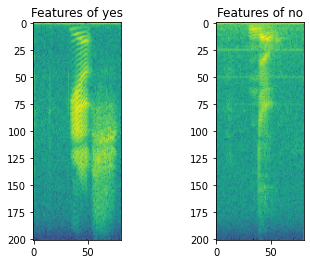

In [ ]:
show_spectrogram(yes_waveform, no_waveform)

y축은 frequency이고 x축은 시간이다. 이미지의 양상은 pitch나 amplitude이다. 집중된 노란색은 이미지의 aplitude를 보여주는 것이다 .

#### Mel spectrogram

- 스텍트로그램처름 frequency를 시간축에 매핑한 것이지만, mel-scale을 활용한다는 점이 다르다. 
- 멜 스펙트로그램은 frequency를 mel-scale 범위로 볌환하고 스펙트로그램으로 바꾸어 돌려준다. 

In [ ]:
def show_melspectrogram(waveform, sample_rate):
  mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
  print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

  plt.figure()
  plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
  

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape of spectrogram: torch.Size([1, 128, 81])


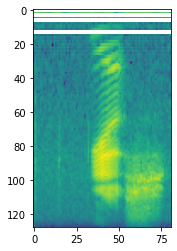

In [ ]:
show_melspectrogram(yes_waveform, yes_sample_rate)

#### Mel-frequency cepstral coefficients(MFCC)

mfcc에 대한 간단한 설명은 frequency를 활용해서 변환에 활용한다는 것이다.  

In [ ]:
def show_mfcc(waveform, sample_rate):
  mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)
  print(f'Shape of spectrogram : {mfcc_spectrogram.size()}')

  plt.figure()
  fig1 = plt.gcf()
  plt.imshow(mfcc_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')

  plt.figure()
  plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
  plt.draw()



/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape of spectrogram : torch.Size([1, 40, 81])


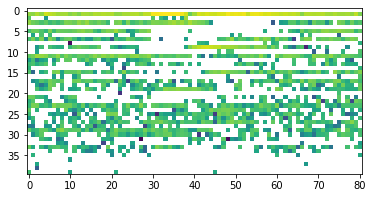

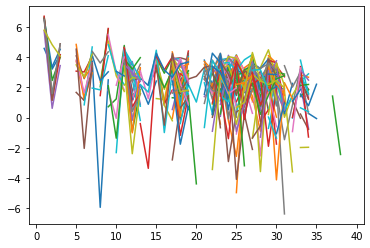

In [ ]:
show_mfcc(no_waveform, no_sample_rate)

In [ ]:
help(os.makedirs)

Help on function makedirs in module os:

makedirs(name, mode=511, exist_ok=False)
    makedirs(name [, mode=0o777][, exist_ok=False])
    
    Super-mkdir; create a leaf directory and all intermediate ones.  Works like
    mkdir, except that any intermediate path segment (not just the rightmost)
    will be created if it does not exist. If the target directory already
    exists, raise an OSError if exist_ok is False. Otherwise no exception is
    raised.  This is recursive.



In [ ]:
#스펙트로그램으로 이미지 만들기
def create_spectrogram_img(trainloader, label_dir):

  directory = data_dir + f'/spectrograms/{label_dir}'
  if os.path.isdir(directory):
    print('Data exsists for,', label_dir)
  else:
    os.makedirs(directory, mode=0o777, exist_ok=label_dir)

  for i, data in enumerate(trainloader):

    waveforms = data[0]
    sample_rate = data[1][0]
    label = data[2]
    ID = data[3]

    #create transformed waveforms
    spectromgram_tensor = torchaudio.transforms.Spectrogram()(waveform)

    fig = plt.figure()
    plt.imsave(directory + f'/spec_img{i}.png', spectromgram_tensor.log2()[0, :, :].numpy(), cmap='viridis')
    plt.close()

In [ ]:
def create_mfcc_images(trainloader, label_dir):

  directory = data_dir + f'/mfcc_spectrograms/{label_dir}'
  if os.path.isdir(directory):
    print('Data exsists for,', label_dir)
  
  else:
    os.makedirs(directory, mode=0o777, exsist_ok=True)

  for i, data in enumerate(trainloader):

    waveform = data[0]
    sample_rate = data[1][0]
    label = data[2]
    ID = data[3]

    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram[0].log2[0,:,:].numpy(), cmap='virdirs')
    plt.draw()
    fig1.savefig(directory + f'/spec_img{i}.png', dpi=100)
    plt.close()



In [ ]:
create_spectrogram_img(trainloader_yes, 'yes')
create_spectrogram_img(trainloader_no, 'no')

Data exsists for, yes
Data exsists for, no
